In [1]:
import pandas as pd
from pathlib import Path

# Get the absolute path of the current script
ScriptPath = Path().absolute()
# Read the pickle file into a DataFrame
df=pd.read_pickle(ScriptPath.parent / 'data' / 'cus1.pkl')


In [2]:
# ============================================================ # 1. Imports # ================
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 


# schöneres Plot-Design 
plt.style.use("seaborn-v0_8")
# ============================================================ # 2. Datenvorbereitung # ============================
df = df.sort_values('time_sec').reset_index(drop=True) 
df.head()



,time_sec,CUS1_PrecipitationIntensity,CUS1_AirTemperature,CUS1_RelativeHumidity,CUS1_AtmosphericPressure,CUS1_WindSpeed,CUS1_WindDirection,CUS1_SunAzimuth,CUS1_SunElevation
0,2024-06-06 07:13:35.694,0.0,14.4,70.8,1017.8,0.32,46.6,97.4,35.3
1,2024-06-06 07:13:38.705,0.0,14.4,71.0,1017.8,0.25,21.3,97.5,35.3
2,2024-06-06 07:13:41.704,0.0,14.4,71.2,1017.8,0.57,31.4,97.5,35.3
3,2024-06-06 07:13:44.718,0.0,14.4,71.3,1017.8,1.02,21.6,97.5,35.3
4,2024-06-06 07:13:47.725,0.0,14.4,71.4,1017.8,1.01,26.6,97.5,35.3


count                     16954957
mean     0 days 00:00:03.004807561
std      0 days 00:00:01.442791116
min                0 days 00:00:00
25%         0 days 00:00:02.999000
50%                0 days 00:00:03
75%         0 days 00:00:03.001000
max         0 days 00:57:29.946000
Name: delta_time, dtype: object
gaps length: 4983


c:\Users\syassinho\.conda\envs\NBEAT\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


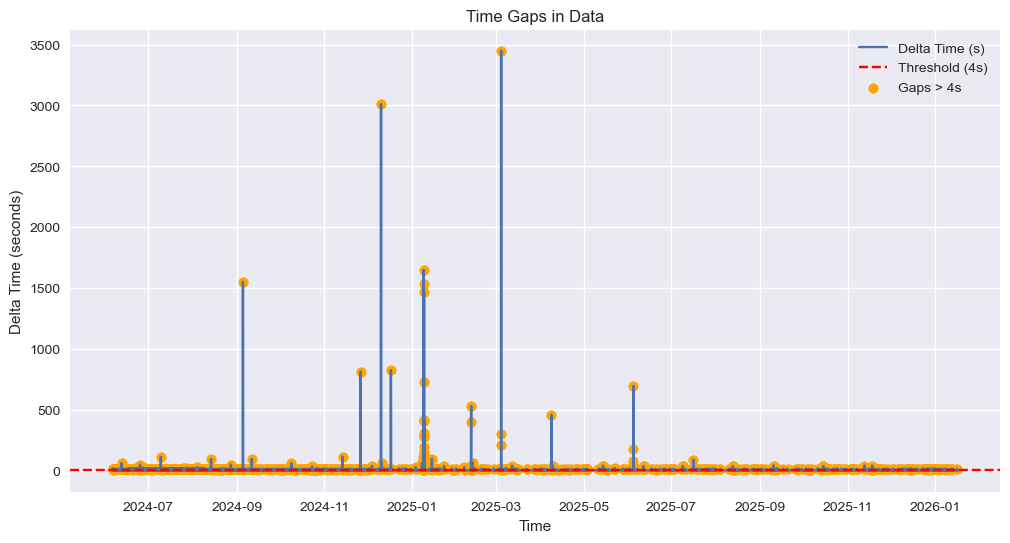

In [4]:
# ============================================================ # 3. Lückenanalyse # ============================
# Berechnung der Zeitdifferenzen
df_diff = df.copy()
df_diff['delta_time']=df['time_sec'].diff()
print(df_diff['delta_time'].describe())
# Identifikation der Lücken
gaps = df_diff[df_diff['delta_time'] > pd.Timedelta(seconds=4)] # Beispiel: Lücken größer als 4 Sekunde
print(f"gaps length: {len(gaps)}")

 
import matplotlib.pyplot as plt  
plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(df_diff['time_sec'], df_diff['delta_time'].dt.total_seconds(), label='Delta Time (s)')
plt.axhline(y=4, color='r', linestyle='--', label='Threshold (4s)')
plt.scatter(gaps['time_sec'], gaps['delta_time'].dt.total_seconds(), color='orange', label='Gaps > 4s')
plt.xlabel('Time')  
plt.ylabel('Delta Time (seconds)')
plt.title('Time Gaps in Data')
plt.legend()
plt.show()  


In [5]:
print(df.columns)

Index(['time_sec', 'CUS1_PrecipitationIntensity', 'CUS1_AirTemperature',
       'CUS1_RelativeHumidity', 'CUS1_AtmosphericPressure', 'CUS1_WindSpeed',
       'CUS1_WindDirection', 'CUS1_SunAzimuth', 'CUS1_SunElevation'],
      dtype='object')


In [6]:
#  ============================================================ # STARTE NAN-ANALYSE FÜR PHYSIKALISCHE GRÖSSEN # ============================
def nan_summary(df):
    '''
    Erstellt eine Zusammenfassung der NaN-Werte für physikalische Messgrößen im DataFrame.

    '''
# Definiere die physikalischen Spalten
    phys_cols = ['time_sec', 'CUS1_PrecipitationIntensity','CUS1_AirTemperature', 'CUS1_RelativeHumidity','CUS1_AtmosphericPressure', 'CUS1_WindSpeed', 'CUS1_WindDirection',
       'CUS1_SunAzimuth', 'CUS1_SunElevation']
    phys_cols=[col for col in phys_cols if col in df.columns]
    df_copy = df.copy()
    for col in phys_cols:
        df_copy[col + '_is_nan'] = df_copy[col].isna().astype(int)
    summary = df_copy[[col + '_is_nan' for col in phys_cols]].sum()
    return summary
#
print(nan_summary(df))


time_sec_is_nan                         0
CUS1_PrecipitationIntensity_is_nan      0
CUS1_AirTemperature_is_nan              0
CUS1_RelativeHumidity_is_nan            0
CUS1_AtmosphericPressure_is_nan         0
CUS1_WindSpeed_is_nan                 114
CUS1_WindDirection_is_nan             114
CUS1_SunAzimuth_is_nan                  0
CUS1_SunElevation_is_nan                0
dtype: int64


In [7]:
#---------------------------------------------- Dart Cleaning for just temperature--------------------------------------------------------
import pandas as pd
from darts import TimeSeries
from darts.dataprocessing.transformers import MissingValuesFiller


print("Cleaning data without full copy...")

# 1) Nur benötigte Spalten
df_clean = df.copy()



print(f"Original rows: {len(df)}")
print(f"After removing duplicates: {len(df_clean)}")


Cleaning data without full copy...
Original rows: 16954958
After removing duplicates: 16954958


In [8]:

# 3) time_sec in echten DatetimeIndex umwandeln
df_clean['time_sec'] = pd.to_datetime(df_clean['time_sec'])

# 4) Zeit als Index setzen
#df_clean = df_clean.set_index('time_sec')

# 5) Auf 3 Sekunden resamplen → erzeugt lückenlosen Zeitindex
#df_clean = df_clean.resample('3s').mean()


df_clean['time_sec'] = df_clean['time_sec'].dt.floor('3s')
df_clean = df_clean.drop_duplicates(subset=['time_sec'], keep='first')

df_clean = df_clean.set_index('time_sec')
# 2) Doppelte Zeitstempel entfernen

# 6) Fehlende Werte füllen
#df_clean = df_clean.ffill().bfill()



In [9]:
phys_col= df_clean.columns.tolist()
print(f"Physikalische Spalten: {phys_col}")

Physikalische Spalten: ['CUS1_PrecipitationIntensity', 'CUS1_AirTemperature', 'CUS1_RelativeHumidity', 'CUS1_AtmosphericPressure', 'CUS1_WindSpeed', 'CUS1_WindDirection', 'CUS1_SunAzimuth', 'CUS1_SunElevation']


In [10]:
from darts import concatenate
phys_col= df_clean.columns.tolist()
print(f"Physikalische Spalten: {phys_col}")
ts_all= None
for col in phys_col:
# 7) Direkt in Darts TimeSeries umwandeln (ohne reset_index!)
    ts = TimeSeries.from_dataframe(
    df_clean,
    value_cols=[col],
    fill_missing_dates=True ,  # wichtig!
    freq='3s'               # wichtig!
    )

    filler= MissingValuesFiller()
    ts_filled = filler.transform(ts, method="linear")

    print(f"✅ Funktioniert! {len(ts)} regelmäßige Punkte")
    print(f"Frequenz erkannt: {ts.freq}")
    if ts_all is None: ts_all = ts_filled 
    else: ts_all = concatenate([ts_all, ts_filled], axis=1)

Physikalische Spalten: ['CUS1_PrecipitationIntensity', 'CUS1_AirTemperature', 'CUS1_RelativeHumidity', 'CUS1_AtmosphericPressure', 'CUS1_WindSpeed', 'CUS1_WindDirection', 'CUS1_SunAzimuth', 'CUS1_SunElevation']
✅ Funktioniert! 16982129 regelmäßige Punkte
Frequenz erkannt: <3 * Seconds>
✅ Funktioniert! 16982129 regelmäßige Punkte
Frequenz erkannt: <3 * Seconds>
✅ Funktioniert! 16982129 regelmäßige Punkte
Frequenz erkannt: <3 * Seconds>
✅ Funktioniert! 16982129 regelmäßige Punkte
Frequenz erkannt: <3 * Seconds>
✅ Funktioniert! 16982129 regelmäßige Punkte
Frequenz erkannt: <3 * Seconds>
✅ Funktioniert! 16982129 regelmäßige Punkte
Frequenz erkannt: <3 * Seconds>
✅ Funktioniert! 16982129 regelmäßige Punkte
Frequenz erkannt: <3 * Seconds>
✅ Funktioniert! 16982129 regelmäßige Punkte
Frequenz erkannt: <3 * Seconds>


<Axes: xlabel='time_sec'>

c:\Users\syassinho\.conda\envs\NBEAT\Lib\site-packages\IPython\core\events.py:96: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\syassinho\.conda\envs\NBEAT\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\syassinho\.conda\envs\NBEAT\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\syassinho\.conda\envs\NBEAT\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


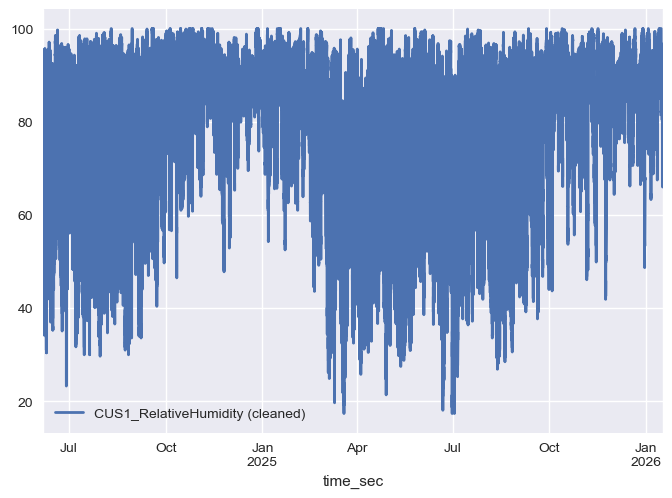

In [6]:
ts_all['CUS1_RelativeHumidity'].plot(label='CUS1_RelativeHumidity (cleaned)')

In [9]:
# Lückenanalyse nach Dart Cleaning
gapses=ts_all.gaps(mode='all')
print(gapses)

Empty DataFrame
Columns: [gap_start, gap_end]
Index: []


In [10]:
# Testen ob keine Lücke in unserem Databases steht 

time_index = ts_all.time_index  # pandas DatetimeIndex
delta_from_index = pd.Series(time_index).diff()
gapses = delta_from_index > pd.Timedelta(seconds=4) # Beispiel: Lücken größer als 4 Sekunde
gapses.describe()

count     16982129
unique           1
top          False
freq      16982129
Name: time_sec, dtype: object

In [12]:
# ================= umbenennen und reset der timestamp spalte
df_from_ts_all = ts_all.to_dataframe(copy=True).reset_index()
df_from_ts_all.head()
print(nan_summary(df_from_ts_all)) # NAN summary

time_sec_is_nan                       0
CUS1_PrecipitationIntensity_is_nan    0
CUS1_AirTemperature_is_nan            0
CUS1_RelativeHumidity_is_nan          0
CUS1_AtmosphericPressure_is_nan       0
CUS1_WindSpeed_is_nan                 0
CUS1_WindDirection_is_nan             0
CUS1_SunAzimuth_is_nan                0
CUS1_SunElevation_is_nan              0
dtype: int64


In [13]:
df_from_ts_all.head()


,time_sec,CUS1_PrecipitationIntensity,CUS1_AirTemperature,CUS1_RelativeHumidity,CUS1_AtmosphericPressure,CUS1_WindSpeed,CUS1_WindDirection,CUS1_SunAzimuth,CUS1_SunElevation
0,2024-06-06 07:13:33,0.0,14.4,70.8,1017.8,0.32,46.6,97.4,35.3
1,2024-06-06 07:13:36,0.0,14.4,71.0,1017.8,0.25,21.3,97.5,35.3
2,2024-06-06 07:13:39,0.0,14.4,71.2,1017.8,0.57,31.4,97.5,35.3
3,2024-06-06 07:13:42,0.0,14.4,71.3,1017.8,1.02,21.6,97.5,35.3
4,2024-06-06 07:13:45,0.0,14.4,71.4,1017.8,1.01,26.6,97.5,35.3


,time_sec,CUS1_PrecipitationIntensity,AirTemperature,CUS1_AirTemperature,CUS1_RelativeHumidity,CUS1_AtmosphericPressure,CUS1_WindSpeed,CUS1_WindDirection,CUS1_SunAzimuth,CUS1_SunElevation,delta_time
0,2024-06-06 07:13:33,0.0,14.4,14.4,70.8,1017.8,0.32,46.6,97.4,35.3,NaT
1,2024-06-06 07:13:36,0.0,14.4,14.4,71.0,1017.8,0.25,21.3,97.5,35.3,0 days 00:00:03.011000
2,2024-06-06 07:13:39,0.0,14.4,14.4,71.2,1017.8,0.57,31.4,97.5,35.3,0 days 00:00:02.999000
3,2024-06-06 07:13:42,0.0,14.4,14.4,71.3,1017.8,1.02,21.6,97.5,35.3,0 days 00:00:03.014000
4,2024-06-06 07:13:45,0.0,14.4,14.4,71.4,1017.8,1.01,26.6,97.5,35.3,0 days 00:00:03.007000


In [16]:
df_clean.head()

,time_sec,CUS1_PrecipitationIntensity,CUS1_AirTemperature,CUS1_RelativeHumidity,CUS1_AtmosphericPressure,CUS1_WindSpeed,CUS1_WindDirection,CUS1_SunAzimuth,CUS1_SunElevation
0,2024-06-06 07:13:33,0.0,14.4,70.8,1017.8,0.32,46.6,97.4,35.3
1,2024-06-06 07:13:36,0.0,14.4,71.0,1017.8,0.25,21.3,97.5,35.3
2,2024-06-06 07:13:39,0.0,14.4,71.2,1017.8,0.57,31.4,97.5,35.3
3,2024-06-06 07:13:42,0.0,14.4,71.3,1017.8,1.02,21.6,97.5,35.3
4,2024-06-06 07:13:45,0.0,14.4,71.4,1017.8,1.01,26.6,97.5,35.3


C:\Users\syassinho\AppData\Local\Temp\ipykernel_11340\173533366.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\syassinho\.conda\envs\NBEAT\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


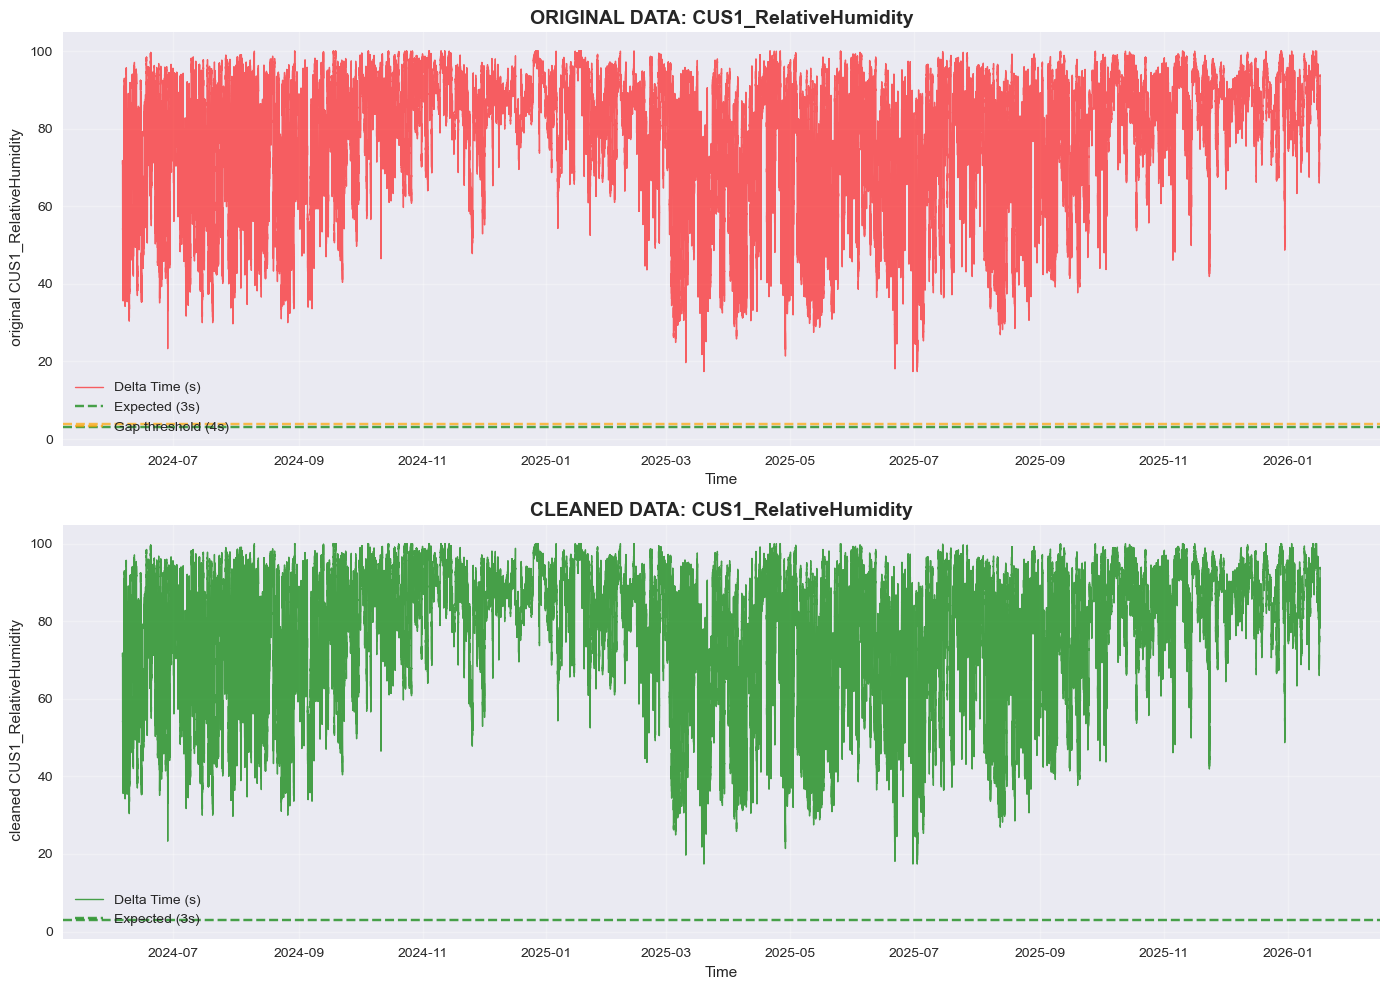

In [ ]:
def vergleiche_dataframes(Phys_col):
    """
    Vergleicht zwei DataFrames und gibt die Anzahl der Zeilen und Spalten zurück.
   """
    #df_clean.reset_index(inplace=True)

    fig, axes = plt.subplots(2, 1, figsize=(14, 10))

    # Plot 1: ORIGINAL DATA - Delta Time
    axes[0].set_title(f'ORIGINAL DATA: {Phys_col}', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    axes[0].plot(df_clean['time_sec'], df_clean[Phys_col], label='Delta Time (s)', color='red', alpha=0.6, linewidth=1)
    axes[0].axhline(y=3, color='g', linestyle='--', label='Expected (3s)', alpha=0.7)
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel(f' original {Phys_col}')
    axes[0].legend()

    # Plot 2: CLEANED DATA - Delta Time
    axes[1].set_title(f'CLEANED DATA: {Phys_col}', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    axes[1].plot(df_from_ts_all['time_sec'], df_from_ts_all[Phys_col], label='Delta Time (s)', color='green', alpha=0.7, linewidth=1)
    axes[1].axhline(y=3, color='g', linestyle='--', label='Expected (3s)', alpha=0.7)
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel(f' cleaned {Phys_col}')
    axes[1].legend()

    plt.tight_layout()
    plt.show()
    
vergleiche_dataframes('CUS1_RelativeHumidity')